## 导包

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path='./Data/Macro/processed_macro_monthly.csv'
data_dim=100000

## 导入数据

In [14]:
macro_df=pd.read_csv(data_path,index_col=0)
macro_df,macro_df.shape

(                                  2007-01      2007-02      2007-03  \
 20230830-Au_Cu(COMEX)            244.5900   259.432000   224.254545   
 20230830-CEM(yoy)                 16.2600    11.255333    31.630000   
 20230830-CPI(food-yoy)             5.3900     5.866667     5.681818   
 20230830-CPI(mom)                  1.0150     1.166667     0.904545   
 20230830-CPI(non-food-yoy)         1.0650     0.966667     0.904545   
 20230830-CPI(yoy)                  2.4845     2.596667     2.538182   
 20230830-CRB-IND                 440.2095   440.616000   457.632273   
 20230830-CRB-metal               707.1355   718.031333   783.032727   
 20230830-DBI                    4464.2000  4389.400000  5123.136364   
 20230830-Electricity(yoy)         14.6950    15.447333    27.310000   
 20230830-Enterprise(debt-yoy)     16.6150    16.700000    16.845455   
 20230830-Enterprise(EX-yoy)       24.4400    25.800000    25.636364   
 20230830-Enterprise(INV-yoy)      18.1300    18.300000    18.30

## 数据预处理

#### 由于需要embedding操作，因此要对原始数据进行标准化

In [15]:
# 使用 MinMaxScaler 对每一行进行标准化到 [0, 1] 范围内
scaler = MinMaxScaler(feature_range=(0, data_dim-1))
scaled_values = (scaler.fit_transform(macro_df.values.T).T)
# 将结果转换为 DataFrame
macro_df = pd.DataFrame(scaled_values, index=macro_df.index, columns=macro_df.columns)
# 显示结果
macro_df=macro_df.astype(int) #这里将所有指标转变为0-99999，是为了之后可以进行embedding操作
macro_df.head() 


,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
20230830-Au_Cu(COMEX),10528,13182,6892,1645,1593,1596,0,2879,4146,5206,...,51453,51438,49745,48518,52037,56737,62278,58920,57767,59033
20230830-CEM(yoy),67203,57613,96657,63657,42293,63831,75189,63956,58273,61478,...,37908,36811,26127,12474,12474,12474,49104,38555,35177,33170
20230830-CPI(food-yoy),37871,39645,38957,44660,44855,47424,56819,70477,82934,82583,...,45994,35490,33373,38281,31566,26902,21908,20754,25221,16225
20230830-CPI(mom),62060,67090,58397,30766,23238,34556,40759,53199,65708,49955,...,33824,24930,24666,41663,24936,17051,22759,22925,21764,30809
20230830-CPI(non-food-yoy),62051,60094,58857,62179,61310,60757,60757,59372,58767,61200,...,65281,62748,62748,63743,56430,48081,44236,41549,31753,35525


In [16]:
class MyDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len
     #由于是时序数据，因此总长度应该要减去时序长度

    def __getitem__(self, idx):
        # idx is the starting index of the sequence
        sample = self.data[idx:idx + self.seq_len + 1, :]
        # The last element is the target embedding
        return torch.tensor(sample[:-1, :]), torch.tensor(sample[-1, :])

## 模型声明

In [17]:
class MyDecoderLayer(nn.Module):
    def __init__(self, hidden_size, num_heads=1):
        super(MyDecoderLayer, self).__init__()

        self.self_attention = nn.MultiheadAttention(hidden_size, num_heads)
        self.feedforward = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x):
        # 带掩码的自注意力机制
        attn_output, _ = self.self_attention(x, x, x, attn_mask=self.generate_mask(x.size(0)))
        # 残差链接
        x = x + attn_output
        x = self.norm1(x)
        # 前馈神经网络
        ff_output = self.feedforward(x)
        # 残差链接
        x = x + ff_output
        x = self.norm2(x)
        return x

    def generate_mask(self, size):
        # 生成上三角掩码
        mask = torch.triu(torch.ones(size, size), diagonal=1).to(device)
        return mask
    
class MyTransformerDecoder(nn.Module):
    def __init__(self,input_size, hidden_size,  num_layers=1,num_heads=1):
        super(MyTransformerDecoder, self).__init__()
        self.product_layer=nn.Linear(input_size,hidden_size)
        self.layer_stack= nn.ModuleList([MyDecoderLayer(hidden_size,num_heads) for _ in range(num_layers)])
        # 线性映射
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        x=self.product_layer(x) # batch ……  seq_len …… num_ind*embeddingsize
       
        x = x.permute(1, 0, 2) # seq_len ……  batch ……  num_ind*embeddingsize

        for layer in self.layer_stack:
            x = layer(x)
        # print(x.shape)
        out = self.fc(x[-1, :, :])  # 仅使用序列的最后一个时间步的输出
        return out


In [36]:
# 数据处理和嵌入层
class DataEmbedding(nn.Module):
    def __init__(self, num_indicators, embedding_size):
        super(DataEmbedding, self).__init__()

        # Embedding layer for each indicator
        self.embeddings = nn.Embedding(data_dim, embedding_size)
        self.activation = nn.Tanh() 

    def forward(self, x):
        # x shape: (Batch_size, Seq_len-1, Num_indicators)
        # print('embedding  ',x.shape)
        embedded_outputs = [self.embeddings(x[:, :, i].unsqueeze(2)) for i in range(x.size(2))]
        
        # Concatenate embeddings along the last dimension
        x_embedded = torch.cat(embedded_outputs, dim=2)
        x_embedded = self.activation(x_embedded)
        return x_embedded.reshape(x.size(0),x.size(1), -1) # 这里相当于将每一个宏观数据的embedding叠在一起了 batch …… seq_len …… num_ind*embeddingsize

## 模型参数和定义

In [46]:
# 数据和模型参数
num_indicators = macro_df.shape[0]
embedding_size = 32
seq_len = 12
hidden_size = 128
num_layers = 2
num_heads = 4
batch_size = 64
num_epochs = 10

# 模型、数据、优化器和损失函数
embedding_layer = DataEmbedding(num_indicators, embedding_size).to(device)
model = MyTransformerDecoder(embedding_size*num_indicators, hidden_size, num_layers, num_heads).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [47]:
# 获取列的数量
num_columns = len(macro_df.columns)
# 按照 1:4 的比例划分列
split_ratio = 0.8  # 测试集占比
num_test_columns = int(num_columns * split_ratio)
# 选择用于测试的列
train_columns = macro_df.columns[:num_test_columns]
# 选择用于训练的列
test_columns = macro_df.columns[num_test_columns:]
# 根据划分的列获取训练集和测试集
train_df = macro_df[train_columns]
test_df = macro_df[test_columns]

train_dataset = MyDataset(train_df.values.T, seq_len) # shape: (Num_months, Num_indicators)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

test_dataset = MyDataset(test_df.values.T, seq_len) #shape: (Num_months, Num_indicators)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 训练

In [48]:
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for input_data, target in train_dataloader:    
        # print(input_data.shape)
        input_data = input_data.to(device) # (Batch_size, Seq_len, Num_indicators)
        target = target.to(device) # Batch_size, Num_indicators

        optimizer.zero_grad()
        # 数据嵌入
        data = embedding_layer(torch.cat((input_data, target.unsqueeze(1)), dim=1))   # batchsize …… seq_len+1 …… embeddingsize
        input_data,target_data=data[:,:-1,:],data[:,-1,:] # batchsize …… seq_len …… num_ind*embeddingsize  #  batchsize  …… num_ind*embeddingsize
        # print("target",target_data.shape)
        # print("input",input_data.shape)

        # 模型前向传播
        output = model(input_data)  # batchsize  …… num_ind*embeddingsize
        # print("output",output.shape)
        # 计算损失
        loss = criterion(output, target_data) # 令两者尽可能的相似
        total_train_loss += loss.item()
        # 反向传播和优化
        loss.backward()
        optimizer.step()

    # 打印训练信息
    
    model.eval()
    with torch.no_grad():
        total_loss = 0.0

        for input_data, target in test_dataloader:
            input_data = input_data.to(device) # (Batch_size, Seq_len, Num_indicators)
            target = target.to(device) # Batch_size, Num_indicators\

            data = embedding_layer(torch.cat((input_data, target.unsqueeze(1)), dim=1))   # batchsize …… seq_len+1 …… embeddingsize
            input_data,target_data=data[:,:-1,:],data[:,-1,:] # batchsize …… seq_len …… num_ind*embeddingsize  #  batchsize  …… num_ind*embeddingsize

            # 模型前向传播
            outputs = model(input_data)  # batchsize  …… embeddingsize

            # 计算损失
            loss = criterion(outputs, target_data)
            total_loss += loss.item()

        # 计算训练集和测试集上的平均损失和准确率
        average_train_loss = total_train_loss / len(train_dataloader)
        average_loss = total_loss / len(test_dataloader)
        train_losses.append(average_train_loss)
        test_losses.append(average_loss)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Train loss: {average_train_loss}, Test Loss: {average_loss:.4f},') if (epoch+1) % 1 == 0 else None

Epoch 1/10, Train loss: 8.960248311360678, Test Loss: 9.0791,
Epoch 2/10, Train loss: 4.64908496538798, Test Loss: 1.6791,
Epoch 3/10, Train loss: 1.0556600491205852, Test Loss: 0.8969,
Epoch 4/10, Train loss: 0.8898775378863016, Test Loss: 0.6769,
Epoch 5/10, Train loss: 0.5633680522441864, Test Loss: 0.4570,
Epoch 6/10, Train loss: 0.49411287903785706, Test Loss: 0.4707,
Epoch 7/10, Train loss: 0.4860734244187673, Test Loss: 0.4364,
Epoch 8/10, Train loss: 0.4483412702878316, Test Loss: 0.4338,
Epoch 9/10, Train loss: 0.4302738904953003, Test Loss: 0.4627,
Epoch 10/10, Train loss: 0.43717412153879803, Test Loss: 0.4309,


## 绘制误差曲线

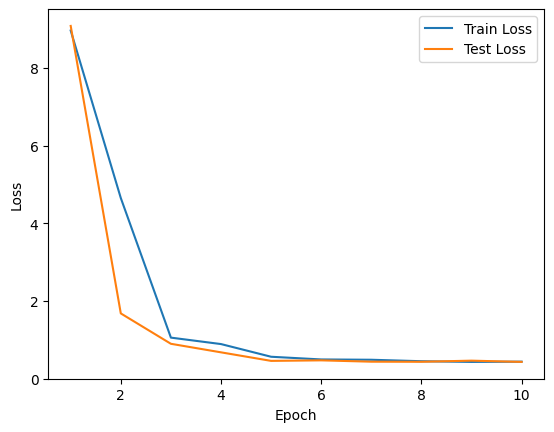

In [49]:
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 将embedding的结果保存下来,方便下次使用

In [50]:
# 保存模型参数到文件
torch.save(embedding_layer.embeddings.state_dict(), 'embedding_params(nn.embedding).pth')

In [52]:
## 接下来使用只需要运行下面代码即可导入训练完的embedding
# 创建一个相同结构的 nn.Embedding 实例
loaded_embedding = nn.Embedding(data_dim, embedding_size)

# 加载保存的参数
loaded_embedding.load_state_dict(torch.load('embedding_params(nn.embedding).pth'))

<All keys matched successfully>